# Storm Swaths Generation

## 0 Setup environment

In [1]:
import os

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
import pandas as pd
from shapely.geometry import Point, Polygon

In [16]:
BASE_PATH = "./data"

BOUNDARIES_FILE = os.path.join(BASE_PATH, "boundaries.gpkg")
TRANSPORT_NETWORK_FILE = os.path.join(BASE_PATH, "merged_network.graphml")
STORM_TRACKS_FILE = os.path.join(BASE_PATH, "ibtracs.ALL.list.v04r01.csv")

## 1 Load storm tracks from IBTrACS

In [3]:
gdf_boundaries = gpd.read_file(BOUNDARIES_FILE)
gdf_boundaries.head()

,town,province,geometry
0,Bacacay,Albay,"MULTIPOLYGON (((123.84193 13.3341, 123.84204 1..."
1,Camalig,Albay,"MULTIPOLYGON (((123.6559 13.06131, 123.65536 1..."
2,Daraga,Albay,"MULTIPOLYGON (((123.71487 13.03995, 123.71474 ..."
3,Guinobatan,Albay,"MULTIPOLYGON (((123.68355 13.25321, 123.67729 ..."
4,Jovellar,Albay,"MULTIPOLYGON (((123.6559 13.06131, 123.65568 1..."


In [4]:
usecols = ["SID", "SEASON", "NATURE", "LAT", "LON", "TOKYO_R30_LONG"]
df_storms = pd.read_csv(STORM_TRACKS_FILE, usecols=usecols, na_values=[" "])

for col in ["SEASON", "LAT", "LON", "TOKYO_R30_LONG"]:
    df_storms[col] = pd.to_numeric(df_storms[col], errors="coerce")

df_storms = df_storms.dropna(subset=["SID", "SEASON", "LAT", "LON"])
print(f"Loaded {df_storms['SID'].nunique()} unique storms and {len(df_storms)} total records.")

/tmp/ipykernel_15572/2726862864.py:2: DtypeWarning: Columns (1,8,9,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df_storms = pd.read_csv(STORM_TRACKS_FILE, usecols=usecols, na_values=[" "])


Loaded 13460 unique storms and 718675 total records.


In [5]:
geometry = [Point(xy) for xy in zip(df_storms["LON"], df_storms["LAT"])]
gdf_storms = gpd.GeoDataFrame(df_storms, geometry=geometry, crs=gdf_boundaries.crs)
gdf_storms.head()

,SID,SEASON,NATURE,LAT,LON,TOKYO_R30_LONG,geometry
1,1842298N11080,1842.0,NR,10.9,80.3,NaN,POINT (80.3 10.9)
2,1842298N11080,1842.0,NR,10.9,79.8,NaN,POINT (79.8 10.9)
3,1842298N11080,1842.0,NR,10.8,79.4,NaN,POINT (79.4 10.8)
4,1842298N11080,1842.0,NR,10.8,78.9,NaN,POINT (78.9 10.8)
5,1842298N11080,1842.0,NR,10.8,78.4,NaN,POINT (78.4 10.8)


## 2 Filter storms along PAR

In [6]:
par_coords = [(120, 25), (135, 25), (135, 5), (115, 5), (115, 15), (120, 21), (120, 25)]
gdf_par = gpd.GeoDataFrame([1], geometry=[Polygon(par_coords)], crs=gdf_boundaries.crs)

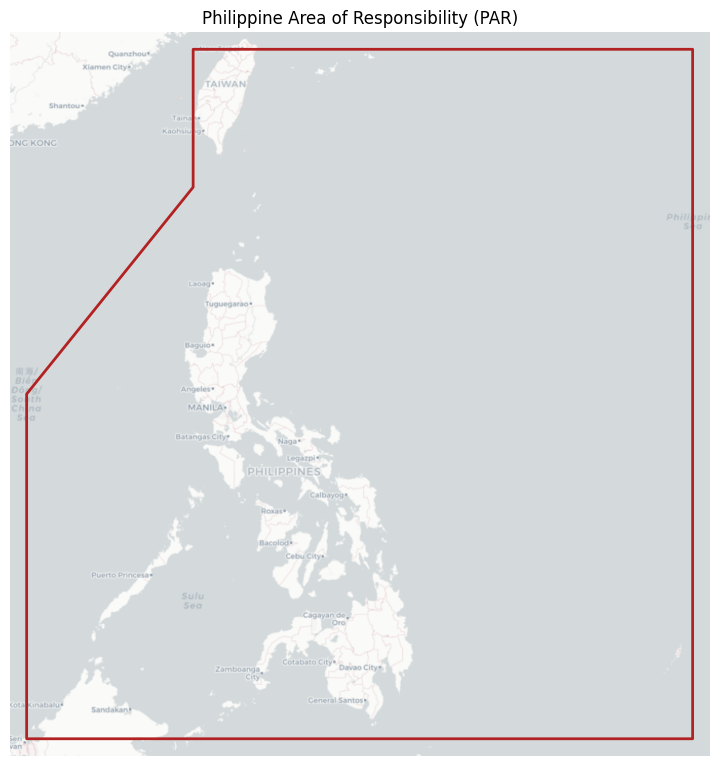

In [8]:
_, ax = plt.subplots(figsize=(8, 8))

gdf_par.plot(ax=ax, color="none", edgecolor="firebrick", linewidth=2)

x_min, y_min, x_max, y_max = gdf_par.total_bounds
padding = 0.5
ax.set_xlim(x_min - padding, x_max + padding)
ax.set_ylim(y_min - padding, y_max + padding)

cx.add_basemap(ax, crs=gdf_boundaries.crs, source=cx.providers.CartoDB.Positron, attribution="")

plt.title("Philippine Area of Responsibility (PAR)")
plt.tight_layout()
plt.axis("off")

filepath = os.path.join(BASE_PATH, "par_polygon.png")
plt.savefig(filepath, dpi=300, bbox_inches="tight")

plt.show()

In [ ]:
sids_in_par = gpd.sjoin(gdf_storms, gdf_par, how="inner", predicate="within")["SID"].unique()
gdf_storms_par = gdf_storms[gdf_storms["SID"].isin(sids_in_par)].copy()
gdf_storms_par = gdf_storms_par[gdf_storms_par["NATURE"] == "TS"]

print(f"Found {len(gdf_storms_par['SID'].unique())} tropical storms that passed through the PAR.")

Found 2662 storms that passed through the PAR.


In [ ]:
_, ax = plt.subplots(figsize=(8, 8))

gdf_par.plot(ax=ax, color="none", edgecolor="firebrick", linewidth=2, zorder=3)

x_min, y_min, x_max, y_max = gdf_par.total_bounds
padding = 0.5
ax.set_xlim(x_min - padding, x_max + padding)
ax.set_ylim(y_min - padding, y_max + padding)

cx.add_basemap(ax, crs=gdf_boundaries.crs, source=cx.providers.CartoDB.Positron, attribution="")

for storm_id in gdf_storms_par["SID"].unique():
    track = gdf_storms_par[gdf_storms_par["SID"] == storm_id]
    ax.plot(track.geometry.x, track.geometry.y, marker="o", linestyle="-", markersize=1, alpha=0.4)

min_year, max_year = int(gdf_storms_par["SEASON"].min()), int(gdf_storms_par["SEASON"].max())
plt.title(f"Storms Along PAR ({min_year}-{max_year})")
plt.axis("off")
plt.tight_layout()

filepath = os.path.join(BASE_PATH, "storm_tracks.png")
plt.savefig(filepath, dpi=300, bbox_inches="tight")

plt.show()

## 3 Generate storm swaths

In [ ]:
nmi_to_meter = 1852
gdf_storms_par["RADIUS_M"] = gdf_storms_par["TOKYO_R30_LONG"] * nmi_to_meter
gdf_storms_par["RADIUS_M"] = gdf_storms_par.groupby("SID")["RADIUS_M"].ffill().bfill()

gdf_storms_par = gdf_storms_par.to_crs("EPSG:32651")

swaths = []
for sid, storm_track in gdf_storms_par.groupby("SID"):
    storm_swath = storm_track.geometry.buffer(storm_track["RADIUS_M"]).union_all()
    swaths.append({"SID": sid, "geometry": storm_swath})

gdf_storms_par = gdf_storms_par.to_crs(gdf_boundaries.crs)

gdf_swaths = gpd.GeoDataFrame(swaths, crs="EPSG:32651")
gdf_swaths = gdf_swaths.to_crs(gdf_boundaries.crs)
gdf_swaths.head()

Generated 2662 swaths for PAR storms.


,SID,geometry
0,1884177N17124,"POLYGON ((119.6299 19.04741, 119.57688 18.9352..."
1,1884186N16125,"POLYGON ((115.02828 17.35736, 114.99692 17.360..."
2,1884191N15127,"POLYGON ((119.16419 22.39553, 119.11645 22.510..."
3,1884201N18129,"POLYGON ((120.66847 24.68557, 120.55177 24.746..."
4,1884208N13127,"POLYGON ((106.48286 15.99222, 106.36064 15.999..."


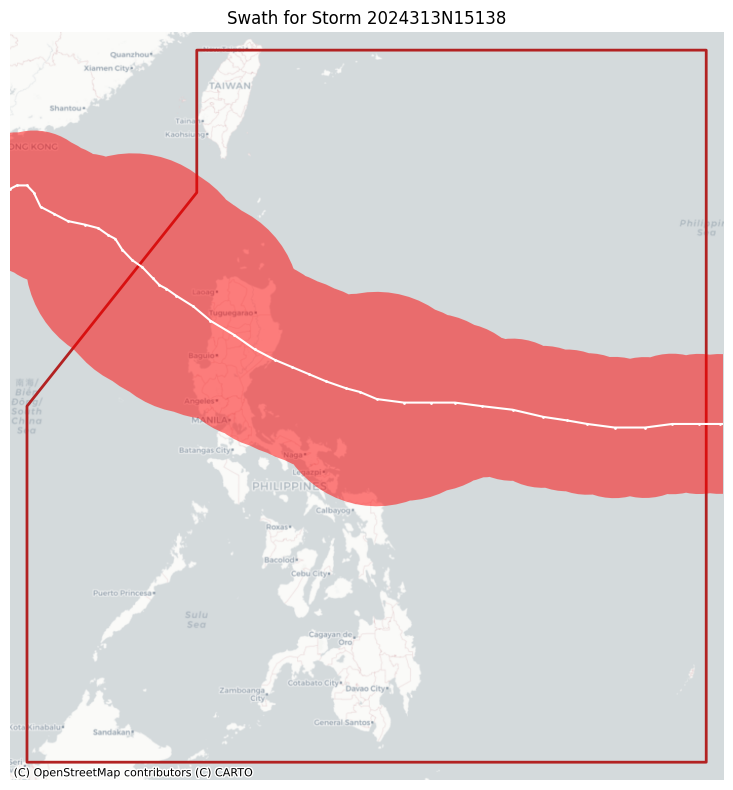

In [14]:
_, ax = plt.subplots(figsize=(8, 8))

gdf_par.plot(ax=ax, color="none", edgecolor="firebrick", linewidth=2)

x_min, y_min, x_max, y_max = gdf_par.total_bounds
padding = 0.5
ax.set_xlim(x_min - padding, x_max + padding)
ax.set_ylim(y_min - padding, y_max + padding)

cx.add_basemap(ax, crs=gdf_boundaries.crs, source=cx.providers.CartoDB.Positron)

storm_id = gdf_storms_par["SID"].unique()[-3]
swath = gdf_swaths[gdf_swaths["SID"] == storm_id]
swath.plot(ax=ax, color="red", alpha=0.5)

track = gdf_storms_par[gdf_storms_par["SID"] == storm_id]
ax.plot(track.geometry.x, track.geometry.y, marker="o", linestyle="-", markersize=1, color="white")

plt.title(f"Swath for Storm {storm_id}")
plt.axis("off")
plt.tight_layout()
plt.show()

## 4 Filter storms that intersect the transport network

In [18]:
graph_transport = ox.load_graphml(TRANSPORT_NETWORK_FILE)
gdf_transport = ox.graph_to_gdfs(graph_transport, nodes=False)
gdf_transport.head()

osmid    highway oneway reversed       length  \
u         v           key                                                       
300744370 2530205870  0     245920268   tertiary  False    False   903.402532   
          12758303623 0     289934621   tertiary  False    False  1174.859606   
          2934697711  0    1185807595   tertiary  False     True   217.508112   
300744933 2530203165  0     291446757  secondary  False     True   142.887806   
          8292228841  0     291446757  secondary  False    False   365.061260   

                                                                    geometry  \
u         v           key                                                      
300744370 2530205870  0    LINESTRING (124.04017 11.76647, 124.03957 11.7...   
          12758303623 0    LINESTRING (124.0277 11.75516, 124.02796 11.75...   
          2934697711  0    LINESTRING (124.03235 11.76396, 124.03309 11.7...   
300744933 2530203165  0    LINESTRING (124.06395 11.76468, 124.06457 11.7...   
          8292228841  0    LINESTRING (124.0623 11.76751, 124.06249 11.76...   

                           mode lanes name  ref bridge service access  \
u         v           key                                               
300744370 2530205870  0    road   NaN  NaN  NaN    NaN     NaN    NaN   
          12758303623 0    road     2  NaN  NaN    NaN     NaN    NaN   
          2934697711  0    road     2  NaN  NaN    NaN     NaN    NaN   
300744933 2530203165  0    road   NaN  NaN  NaN    NaN     NaN    NaN   
          8292228841  0    road   NaN  NaN  NaN    NaN     NaN    NaN   

                          maxspeed width junction tunnel  
u         v           key                                 
300744370 2530205870  0        NaN   NaN      NaN    NaN  
          12758303623 0        NaN   NaN      NaN    NaN  
          2934697711  0        NaN   NaN      NaN    NaN  
300744933 2530203165  0        NaN   NaN      NaN    NaN  
          8292228841  0        NaN   NaN      NaN    NaN

In [ ]:
intersecting_swath_ids = gpd.sjoin(gdf_swaths, gdf_transport, how="inner", predicate="intersects")["SID"].unique()
gdf_swaths = gdf_swaths[gdf_swaths["SID"].isin(intersecting_swath_ids)].copy()
gdf_storms_par = gdf_storms_par[gdf_storms_par["SID"].isin(intersecting_swath_ids)].copy()

print(f"Filtered to {len(intersecting_swath_ids)} storms that intersect the Bicol transport network.")

Filtered to 673 swaths that intersect the Bicol transport network.


## 6 Save data into file

In [ ]:
# TODO: Save image of each storm swath to visually validate its intersection with the transport network.

In [26]:
dirpath = os.path.join(BASE_PATH, "storm_swaths")
os.makedirs(dirpath, exist_ok=True)

for index, row in gdf_swaths.iterrows():
    sid = row["SID"]
    gdf_single_swath = gpd.GeoDataFrame([{"SID": sid, "geometry": row["geometry"]}], crs=gdf_swaths.crs)
    filepath = os.path.join(dirpath, f"{sid}.gpkg")
    gdf_single_swath.to_file(filepath, driver="GPKG")